In [1]:
!pip install /user-home/py_packages/catboost-0.6.3-cp27-none-manylinux1_x86_64.whl

!pip install /user-home/py_packages/mlxtend-0.11.0-py2.py3-none-any.whl

In [1]:
import sys 
sys.path.append('/user-home/1014/code')
from eval_functions import *
from pdp import *

%matplotlib inline

import matplotlib.pyplot as plt

from __future__ import division
import numpy as np
np.random.seed(198908)
import pandas as pd

from sklearn.model_selection import cross_val_score,cross_val_predict
pd.set_option("display.max_columns",999)
from catboost import CatBoostClassifier,CatBoostRegressor,cv
import catboost
import os
os.environ["JOBLIB_TEMP_FOLDER"] = "/tmp"
from sklearn.naive_bayes import GaussianNB 

import xgboost as xgb
import xgbfir
from sklearn.metrics import roc_auc_score, r2_score, make_scorer
from sklearn.model_selection import PredefinedSplit,  cross_val_predict, GridSearchCV, StratifiedKFold, train_test_split, KFold , RandomizedSearchCV

from sklearn.externals import joblib

from sklearn.ensemble import ExtraTreesClassifier, RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

import lightgbm as lgb 

from sklearn.feature_selection import SelectKBest, chi2

from pyearth  import Earth
from xgboost import XGBRegressor


import patsy
from patsy import dmatrix, build_design_matrices

from sklearn.linear_model import LogisticRegressionCV, LogisticRegression

def plot_single_var_response(X,var_name, response_name, bins):
    X['decile']=(bins)-(pd.qcut(X[var_name],bins,labels=False,duplicates='drop'))
    bin_toPlot=X.groupby('decile')[response_name].mean()
    fig, ax = plt.subplots()
    ax.plot(bin_toPlot)
    ax.set_xlabel("Bin")
    ax.set_ylabel("Average Target")
    ax.legend()




def oversample_2class(x,y,prop,seed=0,save_msk_path=None, shuffle=True):
    
    y_pos=y.loc[(y.values).flatten()==1]
    x_pos =x.loc[(y.values).flatten()==1,:]
    
    nb_pos=y_pos.shape[0]
    nb_neg = (nb_pos / prop) - nb_pos
    
    ttl_neg=x.loc[(y.values).flatten()==0,:]
    np.random.seed(seed)
    indx_msk=np.random.choice(a=ttl_neg.shape[0], size=int(nb_neg),replace = False)
    
    sampled_negx=x.iloc[indx_msk,:]
    sampled_negy=y.iloc[indx_msk]
    
    finalx_df=pd.concat([x_pos,sampled_negx],axis=0)
    finaly_df=pd.concat([y_pos,sampled_negy],axis=0)
    
    
    if save_msk_path != None:
        joblib.dump(indx_msk,save_msk_path)
        
    
    if shuffle:
        indx_perm=np.random.permutation(finalx_df.shape[0])
        finalx_df=finalx_df.iloc[indx_perm,:]
        finaly_df=finaly_df.iloc[indx_perm,:]
        
        
        
    return(finalx_df,finaly_df)



from scipy.stats import randint as sp_randint, uniform


#called by callback at the end of each iteration (tree) - save just the best iteration based on cv error
class OOFCallback:
    def  __init__(self, oof_preds_dct, maximize=True):
        
        
        self.oof_preds_dct = oof_preds_dct
        self.best_eval =None
        self.maximize =maximize

    def __call__(self, env): #saved the env object and interogatted it to see what it contained
        
        #look at the current mean OOF eval
        current_eval = env.evaluation_result_list[1][1]
        
        if env.iteration % 10 ==0:
            print("Iteration #"+str(env.iteration))
        
        if self.best_eval == None: #first iteration
            self.best_eval = current_eval
            self.get_oof_preds(env.cvfolds)
        else:
            if self.maximize:
                if self.best_eval < current_eval:
                    self.best_eval = current_eval
                    #replace the actuals and preds
                    self.get_oof_preds(env.cvfolds)
            else:
                if self.best_eval > current_eval:
                    self.best_eval = current_eval
                    #replace the actuals and preds
                    self.get_oof_preds(env.cvfolds)
        
    def get_oof_preds(self, cvfolds):
        #reset the list of actuals and preds
        self.oof_preds_dct['actual']=[]
        self.oof_preds_dct['preds']=[]
        #loop through the folds
        for i, fold in enumerate(cvfolds):
            self.oof_preds_dct['actual'].extend(fold.dtest.get_label())
            self.oof_preds_dct['preds'].extend(fold.bst.predict(fold.dtest))



In [2]:
full=pd.read_csv('/user-home/1014/checking_models/response_rebuild/checking_model_data.txt', na_values=['.', 'null'], dtype={'block_group':np.object, 'census_tract': np.object})
print(full.CAMPAIGN.value_counts())
print(full.responder.value_counts())

scores=pd.read_csv('/user-home/1014/checking_models/response_rebuild/scores.txt', na_values=['.', 'null'])
full=pd.merge(full,scores,how='left',left_on=['CAMPAIGN','Person_Seq_No_1_183'], right_on=['campaign','Person_Seq_No_1_183'])

add_tsp=pd.read_csv('/user-home/1014/checking_models/response_rebuild/additionaltsp.txt', na_values=['.', ' ','','null'])
print(add_tsp.CAMPAIGN.value_counts())
full=pd.merge(full,add_tsp,how='left',left_on=['CAMPAIGN','Person_Seq_No_1_183','date_key_link'], right_on=['CAMPAIGN','Person_Seq_No_1_183','Date_key_link'])

full['DMA_602']=np.where(full.DMA_176.values ==602,1,0)
full['DMA_539']=np.where(full.DMA_176.values ==539,1,0)
full['DMA_505']=np.where(full.DMA_176.values ==505,1,0)
full['DMA_510']=np.where(full.DMA_176.values ==510,1,0)
full['DMA_524']=np.where(full.DMA_176.values ==524,1,0)
full['DMA_534']=np.where(full.DMA_176.values ==534,1,0)
full['DMA_517']=np.where(full.DMA_176.values ==517,1,0)
full['DMA_535']=np.where(full.DMA_176.values ==535,1,0)
full['DMA_528']=np.where(full.DMA_176.values ==528,1,0)
full['DMA_515']=np.where(full.DMA_176.values ==515,1,0)
full['DMA_527']=np.where(full.DMA_176.values ==527,1,0)
full['DMA_563']=np.where(full.DMA_176.values ==563,1,0)
full['DMA_659']=np.where(full.DMA_176.values ==659,1,0)
full['DMA_571']=np.where(full.DMA_176.values ==571,1,0)
full['DMA_529']=np.where(full.DMA_176.values ==529,1,0)
full['DMA_542']=np.where(full.DMA_176.values ==542,1,0)
full['DMA_561']=np.where(full.DMA_176.values ==561,1,0)
full['DMA_548']=np.where(full.DMA_176.values ==548,1,0)
full['DMA_513']=np.where(full.DMA_176.values ==513,1,0)
full['DMA_547']=np.where(full.DMA_176.values ==547,1,0)
full['DMA_560']=np.where(full.DMA_176.values ==560,1,0)




full=full.drop([
#'CAMPAIGN',
'Cell',
'ACCT_KEY',
'hh_key',
#'Person_Seq_No_1_183',
'OPEN_DATE',
'date_key_link',
'full_census',
#'block_group',
'LAT',
'LNG',
#'ZIP_Code_13',
'Post_Office_Name_135',
#'State_Abbreviation_150',
'Contracted_Address_1836',
'census_tract_full',
'DATE_KEY',
#'census_tract',
    #'campaign',
    'Date_key_link','MT_Personal_Traveler_1480'#,'Orig_ID','Person_Seq'
],axis=1)


full.head()

/opt/conda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1,6,26,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


MAR17    1155090
JAN18     555001
OCT17     277501
SEP17     111001
JUL17     111000
Name: CAMPAIGN, dtype: int64
0    2205515
1       4078
Name: responder, dtype: int64


/opt/conda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0,2,3,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


JAN18    41515202
OCT17    41515202
SEP17    28018558
MAR17    27971391
JUL17    27971391
Name: CAMPAIGN, dtype: int64


,CAMPAIGN,Person_Seq_No_1_183,responder,block_group,ZIP_Code_13,State_Abbreviation_150,DMA_176,Number_of_Tradelines_1_261,Advantage_Individual_Age_1_262,Target_ValueScore_20_All_614,Target_ValueScore_20_Aut_616,Target_ValueScore_20_Ban_618,Target_ValueScore_20_Ret_620,Investments_and_Insurance_739,Investments_and_Insurance_744,Advantage_Home_Owner_813,Advantage_Length_of_Residen_823,Advantage_Target_Income_20_876,Target_PreMover_20_Model_879,Target_Net_Worth_20_881,Target_Income_Index_20_882,Current_Loan_to_Value_890,Target_Home_Market_Value_894,Available_home_equity_in_th_899,Home_equity_loan_in_thousan_913,Home_Market_Value_Tax_Reco_918,Second_mortgage_amount_in_t_950,Wealth_Resources_1089,Investment_Resources_1091,Liquid_Resources_1093,Gold_Wallets_1100,Platinum_Wallets_1101,Silver_Wallets_1102,MT_401k_Owners_1148,MT_Credit_Card_Balance_Tr_1254,MT_Credit_Card_Revolvers_1256,collapsed_niche_indx,addresses_BG,addresses_CT,sum_Fullservice_Branch_YesNo,sum_NonRetail_Bank_Branch_YesNo,sum_Denovo_Branch_YesNo,sum_InStore_Branch_YesNo,sum_Headquarters_YesNo,sum_fifth_third,sum_peer,sum_core,sum_trill,sum_CU,total_bankingcenters,avg_Fullservice_Branch_YesNo,avg_NonRetail_Bank_Branch_YesNo,avg_Denovo_Branch_YesNo,avg_InStore_Branch_YesNo,avg_Headquarters_YesNo,avg_fifth_third,avg_peer,avg_core,sum_BBT_Corporation,sum_CapitalOne,sum_Comerica,sum_Huntington,sum_KeyCorp,sum_MTBank,sum_PNC,sum_Regions,sum_SunTrust,sum_USBancorp,sum_WellsFargo,sum_Zions,sum_JPMorganChase,avg_BBT_Corporation,avg_CapitalOne,avg_Comerica,avg_Huntington,avg_KeyCorp,avg_MTBank,avg_PNC,avg_Regions,avg_SunTrust,avg_USBancorp,avg_WellsFargo,avg_Zions,avg_JPMorganChase,avg_CU,total_tape_deposits,NonCU_total_tape_deposits,total_tape_deposits_53,ratio_53_total,ratio_peer_total,ratio_core_total,ratio_CU_total,ratio_53_peer,ratio_53_core,ratio_53_trill,ratio_53_tape_total,ratio_53_tape_NonCU,CD_excludeIRA_AVG_VALUE,CD_IncludeIRA_AVG_VALUE,Fixed_int_Save_exlcudeIRA_AVG_VA,MM_Save_AVG_VALUE,Reg_Liq_Sav_excludeIRA_AVG_VALUE,Savings_AVG_VALUE,VI_Save_excludeIRA_AVG_VALUE,InterDDA_AVG_VALUE,Reg_nonInt_DDA_AVG_VALUE,TransDDA_AVG_VALUE,Deposit_AVG_VALUE,LiquidDep_AVG_VALUE,Ass_CashMan_AVG_VALUE,CD_excludeIRA_Households,CD_IncludeIRA_Households,Fixed_int_Save_exlcudeIRA_Househ,MM_Save_Households,Reg_Liq_Sav_excludeIRA_Household,Savings_Households,VI_Save_excludeIRA_Households,InterDDA_Households,Reg_nonInt_DDA_Households,TransDDA_Households,Deposit_Households,LiquidDep_Households,Ass_CashMan_Households,CD_IncludeIRA_TOTAL,Fixed_int_Save_exlcudeIRA_TOTAL,MM_Save_TOTAL,Reg_Liq_Sav_excludeIRA_TOTAL,Savings_TOTAL,VI_Save_excludeIRA_TOTAL,InterDDA_TOTAL,Reg_nonInt_DDA_TOTAL,TransDDA_TOTAL,Deposit_TOTAL,LiquidDep_TOTAL,Ass_CashMan_TOTAL,A01,A02,A03,A04,B05,B06,B07,B08,C09,C10,C11,C12,D13,D14,D15,D16,E17,E18,E19,E20,F21,F22,F23,F24,G25,G26,G27,G28,H29,H30,H31,I32,J33,J34,J35,J36,K37,K38,K39,L40,L41,L42,M43,M44,M45,M46,M47,N48,N49,N50,N51,O52,O53,P54,P55,P56,P57,Q58,Q59,Q60,R61,total,FE,MA,MM,UB,prop_FE,prop_MA,prop_MM,prop_UB,propA01,propA02,propA03,propA04,propB05,propB06,propB07,propB08,propC09,propC10,propC11,propC12,propD13,propD14,propD15,propD16,propE17,propE18,propE19,propE20,propF21,propF22,propF23,propF24,propG25,propG26,propG27,propG28,propH29,propH30,propH31,propI32,propJ33,propJ34,propJ35,propJ36,propK37,propK38,propK39,propL40,propL41,propL42,propM43,propM44,propM45,propM46,propM47,propN48,propN49,propN50,propN51,propO52,propO53,propP54,propP55,propP56,propP57,propQ58,propQ59,propQ60,propR61,ixi_check_custs_A01,ixi_check_custs_A02,ixi_check_custs_A03,ixi_check_custs_A04,ixi_check_custs_B05,ixi_check_custs_B06,ixi_check_custs_B07,ixi_check_custs_B08,ixi_check_custs_C09,ixi_check_custs_C10,ixi_check_custs_C11,ixi_check_custs_C12,ixi_check_custs_D13,ixi_check_custs_D14,ixi_check_custs_D15,ixi_check_custs_D16,ixi_check_custs_E17,ixi_check_custs_E18,ixi_check_custs_E19,ixi_check_custs_E20,ixi_check_custs_F21,ixi_check_custs_F22,ixi_check_custs_F23,ixi_check_custs_F24,ixi_ch

In [3]:

# Advantage_Target_Income_20_876   
d1={1:1,
2:2,
3:3,
4:4,
5:5,
6:6,
7:7,
8:8,
9:9,
'A':10,
'B':11,
'C':12,
'D':13
}


d2={'Y':1, 'N':0}

#target value score
d3={'A1':1.0,
'A2':2.0,
'B1':3.0,
'B2':4.0,
'C1':5.0,
'C2':6.0,
'D1':7.0,
'D2':8.0,
'D3':9.0
}

#merit score,TriggerVal_ValueScore_1060
d4={'A1':1.0,
'A2':2.0,
'B1':3.0,
'B2':4.0,
'C1':5.0,
'C2':6.0,
'D1':7.0,
'D2':8.0,
'D3':9.0,
'E1':10.0,
'E2':11.0,
'E3':12.0
}


d5={
'A':'10',
'B':'11',
'C':'12',
'D':'13'
}

d6={
'N':'0',
'D':'1',
'I':'-1',
}

d7={
'A':1.0,
    'B':2.0,
    'C':3.0,
    'D':4.0,
    'E':5.0,
    'F':6.0,
    'G':7.0,
    'H':8.0,
    'I':9.0,
    'J':10.0,
    'K':11.0,
    'L':12.0,
    'M':13.0,
    'N':14.0,
    'O':15.0,
    'P':16.0,
    'Q':17.0,
    'Z':18.0
            
}

full['TriggerVal_Home_Market_Valu_1002']=full.TriggerVal_Home_Market_Valu_1002.map(d7)



full['Credit_Card_Trigger_978']=full.Credit_Card_Trigger_978.fillna('N').map(d6)
full['Home_Market_Value_Trigger_1001']=full.Home_Market_Value_Trigger_1001.fillna('N').map(d6)
full['Income_Trigger_1009']=full.Income_Trigger_1009.fillna('N').map(d6)
full['ValueScore_Trigger_1059']=full.ValueScore_Trigger_1059.fillna('N').map(d6)
full['Niche_Switch_Trigger_1068']=full.Niche_Switch_Trigger_1068.fillna('N').map(d6)


#update when dict is not exhuastive (and is inplace!)
full['TriggerVal_Income_1010'].update(full['TriggerVal_Income_1010'].map(d5))
full['TriggerVal_Income_1010']=full['TriggerVal_Income_1010'].fillna('0').astype(float)





full['TriggerVal_ValueScore_1060']=full['TriggerVal_ValueScore_1060'].map(d4)  


full['Merit_Score_1881']=full['Merit_Score_1881'].map(d4)  

full['Mobility_Score_1878']=full['Mobility_Score_1878'].map(d4) 

full['Target_ValueScore_20_All_614']=full['Target_ValueScore_20_All_614'].map(d3)  
full['Target_ValueScore_20_Aut_616']=full['Target_ValueScore_20_Aut_616'].map(d3) 
full['Target_ValueScore_20_Ban_618']=full['Target_ValueScore_20_Ban_618'].map(d3)  
full['Target_ValueScore_20_Ret_620']=full['Target_ValueScore_20_Ret_620'].map(d3)  

full['Investments_and_Insurance_739'].fillna('N',inplace=True)
full['Investments_and_Insurance_744'].fillna('N',inplace=True)
full['Investments_and_Insurance_739']= full['Investments_and_Insurance_739'].map(d2)   
full['Investments_and_Insurance_744']= full['Investments_and_Insurance_744'].map(d2)  

full['Target_Home_Market_Value_894_v']=full.Target_Home_Market_Value_894.str[0:4].fillna(0).astype(float)  
full['Advantage_Target_Income_20_876']=full['Advantage_Target_Income_20_876'].map(d1)  


full['Current_Loan_to_Value_890']=full['Current_Loan_to_Value_890'].fillna(0).astype(float) 
full['Available_home_equity_in_th_899']=full['Available_home_equity_in_th_899'].fillna(0).astype(float)  
full['Advantage_Length_of_Residen_823']=full['Advantage_Length_of_Residen_823'].fillna(0).astype(float)  
full['Target_PreMover_20_Model_879']=full['Target_PreMover_20_Model_879'].fillna(0).astype(float)  

full['Gold_Wallets_1100'].fillna('N',inplace=True)
full['Silver_Wallets_1102'].fillna('N',inplace=True)
full['Platinum_Wallets_1101'].fillna('N',inplace=True)

full['Gold_Wallets_1100']= full['Gold_Wallets_1100'].map(d2)
full['Silver_Wallets_1102']= full['Silver_Wallets_1102'].map(d2) 
full['Platinum_Wallets_1101']= full['Platinum_Wallets_1101'].map(d2)   

full['Liquid_Resources_1093']=full['Liquid_Resources_1093'].astype(float)  
full['Wealth_Resources_1089']=full['Wealth_Resources_1089'].astype(float)  
full['Investment_Resources_1091']=full['Investment_Resources_1091'].astype(float)  


full['income_diff']=full['Advantage_Target_Income_20_876']-full['TriggerVal_Income_1010']

full=full.drop(['Target_Home_Market_Value_894'],axis=1)

In [4]:
full['MDM_household_Share_BG_ixi']=full['MDM_household_Share_BG'] / full['total']
full['PEN_CHECK']=full['SUM_CHECKING_IND_BG'] / full['total_ixi_check_custs']
full['peraddress_53']=full['sum_fifth_third'] / full['addresses_CT']
full['peraddress_bc']=full['total_bankingcenters'] / full['addresses_CT']
full['checking_pen_53_MA_Custs']=full['checking_MA']/full['MA']
full['checking_pen_53_MA_Custs_BG']=full['checking_MA_BG']/full['MA_BG']


In [5]:
#performance of old model on Jan campaign
full_jan = full[(full.CAMPAIGN == 'JAN18')]
print(full_jan.shape)

def resp_decile_classify(x): 
    if x >= 0.02016828: 
        resp_decile_range=1 
    elif x >=0.0183238479987624 and x < 0.02016828:
        resp_decile_range=2
    elif x >=0.0171368020008659 and x < 0.0183238479987624:
        resp_decile_range=3
    elif x >=0.0162066398244529 and x < 0.0171368020008659 :
        resp_decile_range=4
    elif x >=0.0153569084145478 and x < 0.0162066398244529:
        resp_decile_range=5    
    elif x >=0.0145335720355378 and x < 0.0153569084145478:
        resp_decile_range=6
    elif x >=0.0136686706768234 and x < 0.0145335720355378:
        resp_decile_range=7
    elif x >=0.0126610871036991 and x < 0.0136686706768234:
        resp_decile_range=8
    elif x >=0.0111844466793064 and x < 0.0126610871036991:
        resp_decile_range=9
    elif x < 0.0111844466793064:
        resp_decile_range=10
    
    return(resp_decile_range)

full_jan['decile_range']=full_jan.pred.apply(resp_decile_classify) 

(559063, 763)


/opt/conda/lib/python2.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [6]:
def resp_decile_classify(x): 
    if x >= 0.02016828: 
        resp_decile_range=1 
    elif x >=0.0183238479987624 and x < 0.02016828:
        resp_decile_range=2
    elif x >=0.0171368020008659 and x < 0.0183238479987624:
        resp_decile_range=3
    elif x >=0.0162066398244529 and x < 0.0171368020008659 :
        resp_decile_range=4
    elif x >=0.0153569084145478 and x < 0.0162066398244529:
        resp_decile_range=5    
    elif x >=0.0145335720355378 and x < 0.0153569084145478:
        resp_decile_range=6
    elif x >=0.0136686706768234 and x < 0.0145335720355378:
        resp_decile_range=7
    elif x >=0.0126610871036991 and x < 0.0136686706768234:
        resp_decile_range=8
    elif x >=0.0111844466793064 and x < 0.0126610871036991:
        resp_decile_range=9
    elif x < 0.0111844466793064:
        resp_decile_range=10
    
    return(resp_decile_range)

In [7]:
del full


jan_bal_model=pd.read_csv('/user-home/1014/checking_models/score/scored.csv')

jan_high=jan_bal_model[jan_bal_model.pred > 5.622079]
jan_high=jan_high.drop('pred',axis=1)


full_jan=pd.merge(full_jan,jan_high,how='inner',left_on=['Person_Seq_No_1_183'], right_on=['Person_Seq_No_1_183'])
full_jan.groupby('responder').size()



responder
0    185091
1       415
dtype: int64

In [3]:
keep_vars_linear=[
                     
#'DMA_505',
#'DMA_510',
#'DMA_513',
#'DMA_515',
#'DMA_517',
#'DMA_524',
#'DMA_527',
#'DMA_528',
#'DMA_529',
#'DMA_534',
#'DMA_535',
#'DMA_539',
#'DMA_542',
#'DMA_547',
#'DMA_548',
#'DMA_560',
#'DMA_561',
#'DMA_563',
#'DMA_571',
#'DMA_602',
#'DMA_659',
    
    'MDM_hsld_ShrNEW24',
'Target_Home_Market_Value_894_v',
'Advantage_Target_Income_20_876',
'distance',
'MDM_household_Share_BG_ixi',
'MDM_CKBAL_ShareIXI_BG',
'Target_PreMover_20_Model_879',
'MDM_DEPBAL_ShareCLAIR_BG',
'MDM_hsld_ShrNEW24CHK24',

'Advantage_Length_of_Residen_823',
'new_hhs_24',
'PEN_CHECK',

'Merit_Score_1881',
'Mobility_Score_1878',
'new_hhs_12_with_checking',
                 
'ratio_53_core',
'ratio_53_peer',
'ratio_53_tape_NonCU',
'ratio_53_tape_total',
'peraddress_53',
                  'peraddress_bc',
                  'MDM_CKhousehold_ShareFE_BG',
                  'checking_pen_53_MA_Custs_BG',
'Target_Income_Index_20_882',
'Current_Loan_to_Value_890',
'Available_home_equity_in_th_899',
'Home_equity_loan_in_thousan_913',
'Home_Market_Value_Tax_Reco_918',
'Second_mortgage_amount_in_t_950',
'Wealth_Resources_1089',
'Investment_Resources_1091',
'Liquid_Resources_1093',

'prop_FE',
'prop_MA',
'prop_MM',
'prop_UB',
'propA01',
'propA02',
'propA03',
'propA04',
'propB05',
'propB06',
'propB07',
'propB08',
'propC09',
'propC10',
'propC11',
'propC12',
'propD13',
'propD14',
'propD15',
'propD16',
'propE17',
'propE18',
'propE19',
'propE20',
'propF21',
'propF22',
'propF23',
'propF24',
'propG25',
'propG26',
'propG27',
'propG28',
'propH29',
'propH30',
'propH31',
'propI32',
'propJ33',
'propJ34',
'propJ35',
'propJ36',
'propK37',
'propK38',
'propK39',
'propL40',
'propL41',
'propL42',
'propM43',
'propM44',
'propM45',
'propM46',
'propM47',
'propN48',
'propN49',
'propN50',
'propN51',
'propO52',
'propO53',
'propP54',
'propP55',
'propP56',
'propP57',
'propQ58',
'propQ59',
'propQ60',
'propR61'

               
]


In [6]:
keep_vars_linear=['Number_of_Tradelines_1_261',
'Target_ValueScore_20_All_614',
'Target_ValueScore_20_Aut_616',
'Target_ValueScore_20_Ban_618',
'Target_ValueScore_20_Ret_620',
'Investments_and_Insurance_739',
'Investments_and_Insurance_744',
'Advantage_Home_Owner_813',
'Advantage_Length_of_Residen_823',
'Advantage_Target_Income_20_876',
'Target_PreMover_20_Model_879',
'Target_Net_Worth_20_881',
'Target_Income_Index_20_882',
'Current_Loan_to_Value_890',
'Available_home_equity_in_th_899',
'Home_equity_loan_in_thousan_913',
'Home_Market_Value_Tax_Reco_918',
'Second_mortgage_amount_in_t_950',
'Wealth_Resources_1089',
'Investment_Resources_1091',
'Liquid_Resources_1093',
'Gold_Wallets_1100',
'Platinum_Wallets_1101',
'Silver_Wallets_1102',
'MT_401k_Owners_1148',
'MT_Credit_Card_Balance_Tr_1254',
'MT_Credit_Card_Revolvers_1256',
'sum_fifth_third',
'sum_peer',
'sum_core',
'sum_trill',
'sum_CU',
'total_bankingcenters',
'avg_fifth_third',
'ratio_53_total',
'ratio_peer_total',
'ratio_core_total',
'ratio_CU_total',
'ratio_53_peer',
'ratio_53_core',
'ratio_53_trill',
'ratio_53_tape_total',
'ratio_53_tape_NonCU',
'prop_FE',
'prop_MA',
'prop_MM',
'prop_UB',
'propA01',
'propA02',
'propA03',
'propA04',
'propB05',
'propB06',
'propB07',
'propB08',
'propC09',
'propC10',
'propC11',
'propC12',
'propD13',
'propD14',
'propD15',
'propD16',
'propE17',
'propE18',
'propE19',
'propE20',
'propF21',
'propF22',
'propF23',
'propF24',
'propG25',
'propG26',
'propG27',
'propG28',
'propH29',
'propH30',
'propH31',
'propI32',
'propJ33',
'propJ34',
'propJ35',
'propJ36',
'propK37',
'propK38',
'propK39',
'propL40',
'propL41',
'propL42',
'propM43',
'propM44',
'propM45',
'propM46',
'propM47',
'propN48',
'propN49',
'propN50',
'propN51',
'propO52',
'propO53',
'propP54',
'propP55',
'propP56',
'propP57',
'propQ58',
'propQ59',
'propQ60',
'propR61',
'total_ixi_check_custs',
'FE_ixi_check_custs',
'MA_ixi_check_custs',
'MM_ixi_check_custs',
'UB_ixi_check_custs',
'CORE_CROSS_SELL_BG',
'TOTAL_CROSS_SELL_BG',
'meanC_DEPOSIT_BAL_AMT_BG',
'meanC_CHECKING_BAL_AMT_BG',
'new_hhs_24_BG',
'new_hhs_12_BG',
'new_hhs_6_BG',
'prop_new_hhs_24_BG',
'prop_new_hhs_12_BG',
'prop_new_hhs_6_BG',
'new_hhs_24_with_checking_BG',
'new_hhs_12_with_checking_BG',
'new_hhs_6_with_checking_BG',
'BG_prop_6_new_hh_with_check',
'BG_prop_12_new_hh_with_check',
'BG_prop_24_new_hh_with_check',
'BG_prop_all_check_6mon',
'BG_prop_all_check_12mon',
'BG_prop_all_check_24mon',
'new_hhs_24',
'new_hhs_12',
'new_hhs_6',
'prop_new_hhs_24',
'prop_new_hhs_12',
'prop_new_hhs_6',
'new_hhs_24_with_checking',
'new_hhs_12_with_checking',
'new_hhs_6_with_checking',
'prop_6_new_hh_with_check',
'prop_12_new_hh_with_check',
'prop_24_new_hh_with_check',
'prop_all_check_6mon',
'prop_all_check_12mon',
'prop_all_check_24mon',
'distance',
'NUM_OVERDRAFT_QTY_BG',
'NUM_DEPOSITS_QTY_BG',
'NUM_CHECKS_WRITTEN_QTY_BG',
'ACTIVE_CHECKING_ACCT_IND_BG',
'NUM_ELECT_WITHQTY_BG',
'PERSONALCHECKING_BG',
'PERSONALINTERESTCHECKING_BG',
'PREFERRED_BG',
'NUM_OVERDRAFT_QTY',
'NUM_DEPOSITS_QTY',
'NUM_CHECKS_WRITTEN_QTY',
'ACTIVE_CHECKING_ACCT_IND',
'NUM_ELECT_WITHQTY',
'PERSONALCHECKING',
'PERSONALINTERESTCHECKING',
'PREFERRED',
'MDM_household_Share',
'MDM_hsld_ShrNEW24CHK24',
'MDM_hsld_ShrNEW24',
'MDM_household_Share_BG',
'MDM_CKhousehold_Share',
'MDM_CKhousehold_Share_BG',
'MDM_CKhousehold_ShareIXI_BG',
'MDM_CKhousehold_ShareFE_BG',
'MDM_CKhousehold_ShareMA_BG',
'MDM_CKhousehold_ShareMM_BG',
'MDM_CKhousehold_ShareUB_BG',
'MDM_CKhousehold_ShareCLAIRDEP',
'MDM_CKhousehold_ShareCLAIRCK',
'MDM_CKBAL_ShareIXI_BG',
'MDM_DEPBAL_ShareCLAIR_BG',
'MDM_CHKBAL_ShareCLAIR_BG',
'Merit_Score_1881',
'DMA_602',
'DMA_539',
'DMA_505',
'DMA_510',
'DMA_524',
'DMA_534',
'DMA_517',
'DMA_535',
'DMA_528',
'DMA_515',
'DMA_527',
'DMA_563',
'DMA_659',
'DMA_571',
'DMA_529',
'DMA_542',
'DMA_561',
'DMA_548',
'DMA_513',
'DMA_547',
'DMA_560',
'Target_Home_Market_Value_894_v',
'income_diff',
'MDM_household_Share_BG_ixi',
'PEN_CHECK',
'peraddress_53',
'peraddress_bc',
'checking_pen_53_MA_Custs',
'checking_pen_53_MA_Custs_BG']

keep_vars_linear=list(set(keep_vars_linear))


In [8]:
pd.DataFrame(full_jan.columns,columns=['col']).to_csv('/user-home/1014/checking_models/response_rebuild/full_jan_cols.csv',index=False)

jan_18_topBal_y=full_jan.responder

jan_18_topBal_x=full_jan.drop(['CAMPAIGN',
#'Person_Seq_No_1_183',
'responder',
#'block_group',
#'ZIP_Code_13',
'State_Abbreviation_150',
#'DMA_176',
#'Advantage_Individual_Age_1_262',
'MOBI_IND_BG',
'ONLINE_BILL_PAY_IND_BG',
#'census_tract',
'ONLINE_BILL_PAY_IND',
'SelectionProb',
'SamplingWeight',
#'campaign',
#'decile_range'
],axis=1)

jan_18_topBal_y.to_csv('/user-home/1014/checking_models/response_rebuild/jan_18_topBal_y.csv',index=False)
jan_18_topBal_x.to_csv('/user-home/1014/checking_models/response_rebuild/jan_18_topBal_x.csv',index=False)
jan_18_topBal_x.shape

(185506, 756)

<h3>Read in high balance X and y from Jan 18</h3>

In [7]:
jan_18_topBal_y=pd.read_csv('/user-home/1014/checking_models/response_rebuild/jan_18_topBal_y.csv',header=None, names=['responder'])
jan_18_topBal_x=pd.read_csv('/user-home/1014/checking_models/response_rebuild/jan_18_topBal_x.csv')

In [8]:
print(jan_18_topBal_x.shape)
jan_18_topBal_y.shape

(185506, 748)


(185506, 1)

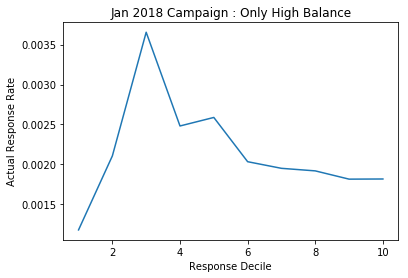

In [21]:
#plot_single_var_response(full_jan,'new_hhs_24','responder',5)
comb=pd.concat([jan_18_topBal_x,jan_18_topBal_y], axis=1)
comb.shape

comb['decile_range']=comb.pred.apply(resp_decile_classify) 

comb.groupby('decile_range')['responder'].agg(['size','sum'])

ax=comb.groupby('decile_range')['responder'].mean().plot(title='Jan 2018 Campaign : Only High Balance')
ax.set_ylabel('Actual Response Rate')
ax.set_xlabel('Response Decile')

del comb


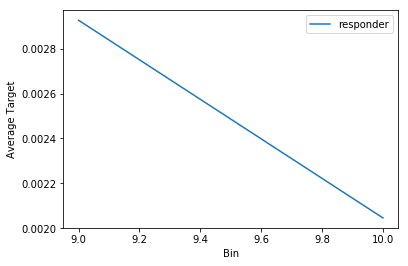

In [73]:
comb=pd.concat([jan_18_topBal_x,jan_18_topBal_y],axis=1)
plot_single_var_response(comb,'ratio_53_tape_total','responder',10)



Iteration #0
Iteration #10
Iteration #20
Iteration #30
Iteration #40
Iteration #50
Iteration #60
Iteration #70
Iteration #80
Iteration #90
Iteration #100
Iteration #110
Iteration #120
Iteration #130
Iteration #140
Iteration #150
Iteration #160
Iteration #170
Iteration #180
Iteration #190
AUC is: 0.634476162432
KS: 0.257482543166
Total Responders: 508.0
Lift Bin 1 (Vs Mean): 3.54330706596
Lift Bin 1 (Vs Last Bin): 3.75


,Decile,Count,Responders,Actual Response Rate,Predicted Response Rate,Lift,Cume Count,Cume Responders,Cume Response Rate,Cume Lift,Min Predicted,Max Predicted
0,1,4150,180,0.043373,0.036165,3.543307,4150,180,0.043373,3.543307,0.014036,0.871083
1,2,4150,41,0.009880,0.012150,0.807087,8300,221,0.026627,2.175197,0.010737,0.014035
2,3,4150,32,0.007711,0.009781,0.629921,12450,253,0.020321,1.660105,0.008961,0.010737
3,4,4150,35,0.008434,0.008289,0.688976,16600,288,0.017349,1.417323,0.007658,0.008960
4,5,4150,39,0.009398,0.007132,0.767717,20750,327,0.015759,1.287402,0.006643,0.007658
5,6,4150,27,0.006506,0.006186,0.531496,24900,354,0.014217,1.161417,0.005745,0.006643
6,7,4150,42,0.010120,0.005343,0.826772,29050,396,0.013632,1.113611,0.004945,0.005745
7,8,4150,35,0.008434,0.004521,0.688976,33200,431,0.012982,1.060531,0.004096,0.004945
8,9,4150,29,0.006988,0.003633,0.570866,37350,460,0.012316,1.006124,0.003128,0.004096
9,10,4150,48,0.011566,0.002398,0.944882,41500,508,0.012241,1.000000,0.000506,0.003128


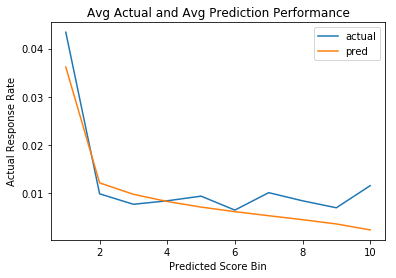

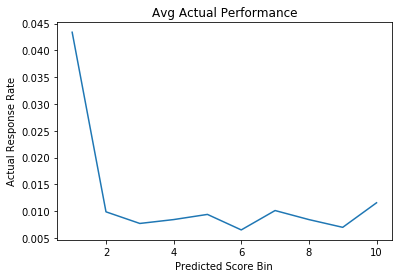

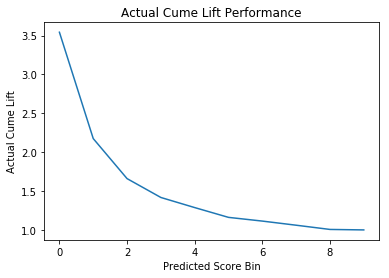

In [6]:
oof_preds_dct1={'actual':[],'preds':[]}
params_xg = {'booster': 'gbtree','max_depth':7, 'eta':0.1, 'silent':0, 'objective':'count:poisson','nthread':8}


jan_18_topBal_x_A=jan_18_topBal_x.copy()
jan_18_topBal_y_A=jan_18_topBal_y.copy()

jan_18_topBal_x_A=jan_18_topBal_x_A[keep_vars_linear]

jan_18_topBal_x_A,jan_18_topBal_y_A =oversample_2class(jan_18_topBal_x_A,pd.DataFrame(jan_18_topBal_y_A.values.reshape(jan_18_topBal_y_A.shape[0],1)),prop=0.01,seed=0,save_msk_path=None, shuffle=True)


dtrain_xg=xgb.DMatrix(jan_18_topBal_x_A.values, label=jan_18_topBal_y_A.values.ravel())
xgb.cv(params=params_xg,dtrain=dtrain_xg,num_boost_round=1500, early_stopping_rounds=30,folds=30,callbacks=[OOFCallback(oof_preds_dct=oof_preds_dct1,maximize=False)])

d=np.column_stack([np.array(oof_preds_dct1['actual']),np.array(oof_preds_dct1['preds'])])
eval_model_results_binary(d,10)

fold 1 completed.
fold 2 completed.
fold 3 completed.
fold 4 completed.
fold 5 completed.
fold 6 completed.
fold 7 completed.
fold 8 completed.
fold 9 completed.
fold 10 completed.
fold 11 completed.
fold 12 completed.
fold 13 completed.
fold 14 completed.
fold 15 completed.
fold 16 completed.
fold 17 completed.
fold 18 completed.
fold 19 completed.
fold 20 completed.
AUC is: 0.5132269682
KS: 0.038642821932
Total Responders: 415.0
Lift Bin 1 (Vs Mean): 1.22888916455
Lift Bin 1 (Vs Last Bin): 1.15909090909


AttributeError: 'DataFrame' object has no attribute 'reshape'

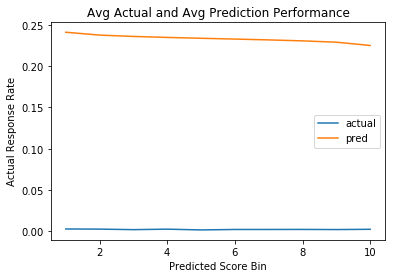

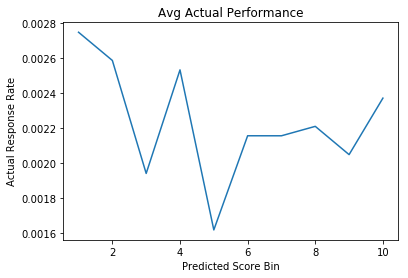

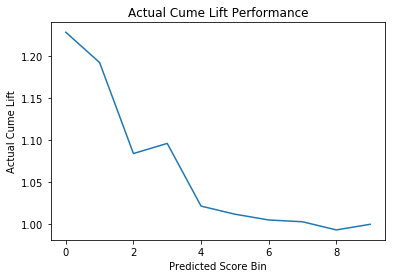

In [46]:
###BUILD OS HERE!!!!!!!!!!!!1


jan_18_topBal_x_A=jan_18_topBal_x.copy()
jan_18_topBal_y_A=jan_18_topBal_y.copy()



hold_results=np.zeros((jan_18_topBal_x_A.shape[0],4))

kf = KFold(n_splits=20,random_state=4528996,shuffle=True) 
counter =1

mod_2=lgb.LGBMClassifier(boosting_type='gbdt', 
              num_leaves=31, 
              max_depth=-1, 
              learning_rate=0.01, 
              n_estimators=30, 
              subsample_for_bin=200000, 
              objective='binary', 
              min_split_gain=0.0, 
              min_child_weight=0.001, 
              min_child_samples=50, 
              subsample=0.7, 
              subsample_freq=1, 
              colsample_bytree=0.7, 
              reg_alpha=0.0, 
              reg_lambda=0.001, 
              random_state=4528, 
              n_jobs=-1, 
              silent=True)
  

mod1=CatBoostClassifier(iterations=40, depth=7, learning_rate=0.01, loss_function='Logloss', verbose=False, eval_metric="AUC",random_seed=4528)
mod2=CatBoostClassifier(iterations=40, depth=7, learning_rate=0.01, loss_function='Logloss', verbose=False, eval_metric="AUC",random_seed=4528)
mod3=CatBoostClassifier(iterations=40, depth=7, learning_rate=0.01, loss_function='Logloss', verbose=False, eval_metric="AUC",random_seed=4528)
mod4=CatBoostClassifier(iterations=40, depth=7, learning_rate=0.01, loss_function='Logloss', verbose=False, eval_metric="AUC",random_seed=4528)
mod5=CatBoostClassifier(iterations=40, depth=7, learning_rate=0.01, loss_function='Logloss', verbose=False, eval_metric="AUC",random_seed=4528)


jan_18_topBal_x_A=jan_18_topBal_x_A[keep_vars_linear]

for train_index, test_index in kf.split(jan_18_topBal_x_A.values):
    X_train, X_test = jan_18_topBal_x_A.iloc[train_index], jan_18_topBal_x_A.iloc[test_index]
    Y_train, Y_test = jan_18_topBal_y_A.values[train_index], jan_18_topBal_y_A.values[test_index]
    
    #oversample the training partition
    x1,y1 =oversample_2class(X_train,pd.DataFrame(Y_train.reshape(Y_train.shape[0],1)),prop=0.025,seed=12564,save_msk_path=None, shuffle=True)
    x2,y2 =oversample_2class(X_train,pd.DataFrame(Y_train.reshape(Y_train.shape[0],1)),prop=0.025,seed=653,save_msk_path=None, shuffle=True)
    x3,y3 =oversample_2class(X_train,pd.DataFrame(Y_train.reshape(Y_train.shape[0],1)),prop=0.025,seed=1258,save_msk_path=None, shuffle=True)
    x4,y4 =oversample_2class(X_train,pd.DataFrame(Y_train.reshape(Y_train.shape[0],1)),prop=0.025,seed=9853,save_msk_path=None, shuffle=True)
    x5,y5 =oversample_2class(X_train,pd.DataFrame(Y_train.reshape(Y_train.shape[0],1)),prop=0.025,seed=41298,save_msk_path=None, shuffle=True)
    
    #fit models to each OS
    
    
    mod1.fit(x1.values,y1.values.ravel())
    mod2.fit(x2.values,y2.values.ravel())
    mod3.fit(x3.values,y3.values.ravel())
    mod4.fit(x4.values,y4.values.ravel())
    mod5.fit(x5.values,y5.values.ravel())
    
    
    
    pred_test1=mod1.predict_proba(X_test.values)[:,1]
    pred_test2=mod2.predict_proba(X_test.values)[:,1]
    pred_test3=mod3.predict_proba(X_test.values)[:,1]
    pred_test4=mod4.predict_proba(X_test.values)[:,1]
    pred_test5=mod5.predict_proba(X_test.values)[:,1]
    
    
    pred_test = (pred_test1+pred_test2+pred_test3+pred_test4+pred_test5)/5
    #hold_results[train_index,0]=Y_train.ravel()
    #hold_results[train_index,1]=pred_train
    hold_results[test_index,2]=Y_test.ravel()
    hold_results[test_index,3]=pred_test
    
    print('fold '+ str(counter)+' completed.')
    
    counter= counter +1
    

    
d=np.column_stack([hold_results[:,2],hold_results[:,3]])
eval_model_results_binary(d,10)

    
    
#oversample all data
x1,y1 =oversample_2class(jan_18_topBal_x_A,pd.DataFrame(jan_18_topBal_y_A.values.reshape(jan_18_topBal_y_A.shape[0],1)),prop=0.025,seed=12564,save_msk_path=None, shuffle=True)
x2,y2 =oversample_2class(jan_18_topBal_x_A,pd.DataFrame(jan_18_topBal_y_A.values.reshape(jan_18_topBal_y_A.shape[0],1)),prop=0.025,seed=653,save_msk_path=None, shuffle=True)
x3,y3 =oversample_2class(jan_18_topBal_x_A,pd.DataFrame(jan_18_topBal_y_A.values.reshape(jan_18_topBal_y_A.shape[0],1)),prop=0.025,seed=1258,save_msk_path=None, shuffle=True)
x4,y4 =oversample_2class(jan_18_topBal_x_A,pd.DataFrame(jan_18_topBal_y_A.values.reshape(jan_18_topBal_y_A.shape[0],1)),prop=0.025,seed=9853,save_msk_path=None, shuffle=True)
x5,y5 =oversample_2class(jan_18_topBal_x_A,pd.DataFrame(jan_18_topBal_y_A.values.reshape(jan_18_topBal_y_A.shape[0],1)),prop=0.025,seed=41298,save_msk_path=None, shuffle=True)
   
mod1.fit(x1.values,y1.values.ravel())
mod2.fit(x2.values,y2.values.ravel())
mod3.fit(x3.values,y3.values.ravel())
mod4.fit(x4.values,y4.values.ravel())
mod5.fit(x5.values,y5.values.ravel())
    


pd.DataFrame(zip(mod1.feature_importances_, jan_18_topBal_x_A.columns),columns=['rank','var']).sort_values('rank', ascending=False)




In [5]:
#STACKING
from sklearn.model_selection import GridSearchCV
from mlxtend.classifier import StackingCVClassifier

RANDOM_SEED=3211
np.random.seed(RANDOM_SEED)



kf = KFold(n_splits=20,random_state=4528996,shuffle=True) 
counter =1

#candidate models
clf0=lgb.LGBMClassifier(boosting_type='gbdt', 
              num_leaves=31, 
              max_depth=-1, 
              learning_rate=0.01, 
              n_estimators=30, 
              subsample_for_bin=200000, 
              objective='binary', 
              min_split_gain=0.0, 
              min_child_weight=0.001, 
              min_child_samples=50, 
              subsample=0.7, 
              subsample_freq=1, 
              colsample_bytree=0.7, 
              reg_alpha=0.0, 
              reg_lambda=0.001, 
              random_state=4528, 
              n_jobs=1, 
              silent=True)
  

clf1=CatBoostClassifier(iterations=40, depth=7, learning_rate=0.01, loss_function='Logloss', verbose=False, eval_metric="AUC",random_seed=4528)


lr = LogisticRegression()




sclf = StackingCVClassifier(classifiers=[clf0, clf1], 
                            meta_classifier=lr,use_probas=True, verbose=10)

params = {'lgbmclassifier__num_leaves': [7,14,31,43],
          'lgbmclassifier__n_estimators': [10,30,50],
          'catboostclassifier__depth': [3,5,7,12],
          'catboostclassifier__iterations': [10,20,40,60],
          'meta-logisticregression__C': [0.1, 10.0]}




#oversample the training partition
x1,y1 =oversample_2class(jan_18_topBal_x,pd.DataFrame(jan_18_topBal_y.values.reshape(jan_18_topBal_y.shape[0],1)),prop=0.025,seed=12564,save_msk_path=None, shuffle=True)
hold_results=np.zeros((x1.shape[0],4))

x1=x1[keep_vars_linear]
    
for train_index, test_index in kf.split(x1.values):
    X_train, X_test = x1.iloc[train_index], x1.iloc[test_index]
    Y_train, Y_test = y1.values[train_index], y1.values[test_index]
    
    
    
 
    
    grid = GridSearchCV(estimator=sclf, 
                    param_grid=params, 
                    cv=5,
                    refit=True,n_jobs=1)
    grid.fit(X_train.values, Y_train.ravel())

    
    
    pred_test=grid.best_estimator_.predict_proba(X_test.values)[:,1]
    
    
    #hold_results[train_index,0]=Y_train.ravel()
    #hold_results[train_index,1]=pred_train
    hold_results[test_index,2]=Y_test.ravel()
    hold_results[test_index,3]=pred_test
    
    print('***********fold '+ str(counter)+' completed.**************')
    
    counter= counter +1
    

    
d=np.column_stack([hold_results[:,2],hold_results[:,3]])
eval_model_results_binary(d,10)

    
#fit all
grid.fit(x1.values,y1.values.ravel())





Fitting 2 classifiers...
Fitting classifier1: lgbmclassifier (1/2)
LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.7,
        learning_rate=0.01, max_depth=-1, min_child_samples=50,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=10,
        n_jobs=1, num_leaves=7, objective='binary', random_state=4528,
        reg_alpha=0.0, reg_lambda=0.001, silent=True, subsample=0.7,
        subsample_for_bin=200000, subsample_freq=1)
Training and fitting fold 1 of 2...
Training and fitting fold 2 of 2...
Fitting classifier2: catboostclassifier (2/2)
Training and fitting fold 1 of 2...
Training and fitting fold 2 of 2...
Fitting 2 classifiers...
Fitting classifier1: lgbmclassifier (1/2)
LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.7,
        learning_rate=0.01, max_depth=-1, min_child_samples=50,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=10,
        n_jobs=1, num_leaves=7, objective='binary', random_sta

KeyboardInterrupt: 

In [81]:
#STACKING NO Grid
from mlxtend.classifier import StackingCVClassifier

RANDOM_SEED=3211
np.random.seed(RANDOM_SEED)


kf = KFold(n_splits=10,random_state=4528996,shuffle=True) 
counter =1

#candidate models
clf0=lgb.LGBMClassifier(boosting_type='gbdt', 
              num_leaves=31, 
              max_depth=-1, 
              learning_rate=0.01, 
              n_estimators=30, 
              subsample_for_bin=200000, 
              objective='binary', 
              min_split_gain=0.0, 
              min_child_weight=0.001, 
              min_child_samples=50, 
              subsample=0.7, 
              subsample_freq=1, 
              colsample_bytree=0.7, 
              reg_alpha=0.0, 
              reg_lambda=0.001, 
              random_state=4528, 
              n_jobs=1, 
              silent=True)
  

clf1=CatBoostClassifier(iterations=40, depth=7, learning_rate=0.01, loss_function='Logloss', verbose=False, eval_metric="AUC",random_seed=4528)
clf2=xgb.XGBClassifier(max_depth=5,learing_rate=0.05,n_estimators=30)
clf3=xgb.XGBClassifier(max_depth=7,learing_rate=0.01,n_estimators=200,objective='count:poisson')
clf4=RandomForestClassifier(n_estimators=500)
clf5=GaussianNB()


rf=RandomForestClassifier(n_estimators=100)


#bug if use shuffle or stratify https://github.com/rasbt/mlxtend/issues/366
sclf = StackingCVClassifier(classifiers=[clf0, clf1, clf2,clf3,clf4,clf5], meta_classifier=rf,use_probas=True, verbose=10,cv=10,store_train_meta_features=True, refit=False, shuffle=False,stratify=False)




#oversample the training partition
x1,y1 =oversample_2class(jan_18_topBal_x,pd.DataFrame(jan_18_topBal_y.values.reshape(jan_18_topBal_y.shape[0],1)),prop=0.01,seed=12564,save_msk_path=None, shuffle=True)
x1=x1[keep_vars_linear]
x1=x1.fillna(-999)
hold_results=np.zeros((x1.shape[0],4))

    
for train_index, test_index in kf.split(x1.values):
    X_train, X_test = x1.iloc[train_index], x1.iloc[test_index]
    Y_train, Y_test = y1.values[train_index], y1.values[test_index]
    
    #fits 'cv' models. Regardless if refit = True or False (just has to do with cloning), the model is retrained with the complete data
    sclf.fit(X_train.values, Y_train.ravel())

    #use model on only the positive event probs
    #fit the level 2 manually
    lr.fit(sclf.train_meta_features_[:,[x for x in range(len(sclf.clfs_)*2) if x%2 !=0]],Y_train)
    #predict meta (level 1)
    meta_x=sclf.predict_meta_features(X_test.values)[:,[x for x in range(len(sclf.clfs_)*2) if x%2 !=0]]
    #predict level 2
    pred_test=lr.predict_proba(meta_x)[:,1]
    
    
    #hold_results[train_index,0]=Y_train.ravel()
    #hold_results[train_index,1]=pred_train
    hold_results[test_index,2]=Y_test.ravel()
    hold_results[test_index,3]=pred_test
    
    print('***********fold '+ str(counter)+' completed.**************')
    
    counter= counter +1
    

    
d=np.column_stack([hold_results[:,2],hold_results[:,3]])
eval_model_results_binary(d,10)

    
#fit all the data
sclf.fit(x1.values,y1.values.ravel())  #used to create meta features
rf.fit(sclf.train_meta_features_[:,[x for x in range(len(sclf.clfs_)*2) if x%2 !=0]],y1.values.ravel()) #level 2 model

NameError: name 'GaussianNB' is not defined

In [77]:
#sclf = StackingCVClassifier(classifiers=[clf0, clf1, clf2], 
#                            meta_classifier=rf,use_probas=True, verbose=10,cv=10,store_train_meta_features=True, refit=True, shuffle=False,stratify=False)

#sclf.fit(x1.values,y1.values.ravel())
#new_X =sclf.train_meta_features_[:,[1]]

#lr=LogisticRegression(C=10000000)
#lr.fit(new_X,y1.values)
#preds=lr.predict_proba(new_X)

#d=np.column_stack([y1.values,preds[:,1]])
#eval_model_results_binary(d,10)


#pd.Series(hold_results[:,3]).plot()
#hold_results[:,3].shape



(41500, 1)

In [ ]:
mod1.save_model('/user-home/1014/checking_models/response_rebuild/mod1_highbal_resp.catboost')
mod2.save_model('/user-home/1014/checking_models/response_rebuild/mod2_highbal_resp.catboost')
mod3.save_model('/user-home/1014/checking_models/response_rebuild/mod3_highbal_resp.catboost')
mod4.save_model('/user-home/1014/checking_models/response_rebuild/mod4_highbal_resp.catboost')
mod5.save_model('/user-home/1014/checking_models/response_rebuild/mod5_highbal_resp.catboost')

fold 1 completed.
fold 2 completed.
fold 3 completed.
fold 4 completed.
fold 5 completed.
fold 6 completed.
fold 7 completed.
fold 8 completed.
fold 9 completed.
fold 10 completed.
fold 11 completed.
fold 12 completed.
fold 13 completed.
fold 14 completed.
fold 15 completed.
fold 16 completed.
fold 17 completed.
fold 18 completed.
fold 19 completed.
fold 20 completed.
AUC is: 0.628417797673
KS: 0.224400420747
Total Responders: 508.0
Lift Bin 1 (Vs Mean): 1.10236220472
Lift Bin 1 (Vs Last Bin): 2.15384615385


,rank,var
23,2.670507,propD15
1,2.505598,BG_prop_24_new_hh_with_check
91,2.268910,Target_Income_Index_20_882
144,2.112445,PERSONALCHECKING_BG
6,1.996736,NUM_DEPOSITS_QTY_BG
14,1.876633,MDM_hsld_ShrNEW24
42,1.683766,peraddress_bc
180,1.559079,prop_all_check_6mon
17,1.518990,ACTIVE_CHECKING_ACCT_IND_BG
47,1.481808,prop_new_hhs_6_BG


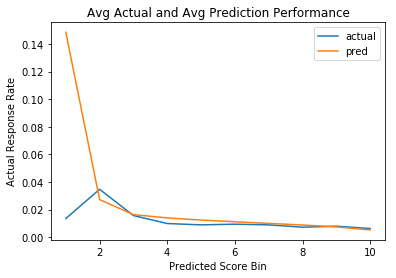

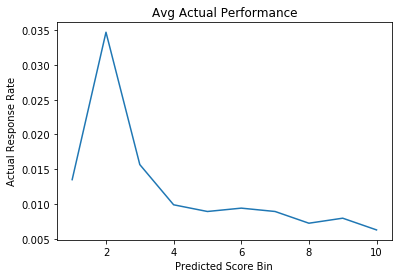

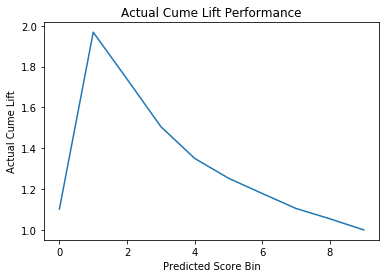

In [85]:
#just tuned catboost model

jan_18_topBal_x_A=jan_18_topBal_x.copy()
jan_18_topBal_y_A=jan_18_topBal_y.copy()


jan_18_topBal_x_A,jan_18_topBal_y_A =oversample_2class(jan_18_topBal_x_A,pd.DataFrame(jan_18_topBal_y_A.values.reshape(jan_18_topBal_y_A.shape[0],1)),prop=0.01,seed=0,save_msk_path=None, shuffle=True)


hold_results=np.zeros((jan_18_topBal_x_A.shape[0],4))

kf = KFold(n_splits=20,random_state=4528996,shuffle=True)
counter =1

mod=CatBoostClassifier(iterations=40, depth=7, learning_rate=0.01, loss_function='Logloss', verbose=False, eval_metric="AUC",random_seed=4528)

jan_18_topBal_x_A=jan_18_topBal_x_A[keep_vars_linear]



params = {'depth':[3,5,9,11],
          'iterations':[10,30,50],
          'learning_rate':[0.03,0.001,0.01,0.1]#, 
          #'l2_leaf_reg':[3,1,5,10,100],
          #'border_count':[32,5,10,20,50,100,200],
          #'ctr_border_count':[50,5,10,20,100,200],
          #'thread_count':4
         }

grid = GridSearchCV(estimator=mod, 
                    param_grid=params, 
                    cv=3,
                    refit=True,n_jobs=1,scoring='roc_auc')

for train_index, test_index in kf.split(jan_18_topBal_x_A.values):
    X_train, X_test = jan_18_topBal_x_A.iloc[train_index], jan_18_topBal_x_A.iloc[test_index]
    Y_train, Y_test = jan_18_topBal_y_A.values[train_index], jan_18_topBal_y_A.values[test_index]
    
    
    #grid search
    grid.fit(X_train.values, Y_train.ravel())
  
    #use best model to predict test
    pred_test=grid.best_estimator_.predict_proba(X_test.values)[:,1]
    
    
    #hold_results[train_index,0]=Y_train.ravel()
    #hold_results[train_index,1]=pred_train
    hold_results[test_index,2]=Y_test.ravel()
    hold_results[test_index,3]=pred_test
    
    print('fold '+ str(counter)+' completed.')
    
    counter= counter +1
    

    
d=np.column_stack([hold_results[:,2],hold_results[:,3]])
eval_model_results_binary(d,10)


grid.fit(jan_18_topBal_x_A.values,jan_18_topBal_y_A.values.ravel())

pd.DataFrame(zip(grid.best_estimator_.feature_importances_, jan_18_topBal_x_A.columns),columns=['rank','var']).sort_values('rank', ascending=False)


0:	learn: 0.6631882	total: 90.4ms	remaining: 814ms
1:	learn: 0.6345030	total: 260ms	remaining: 1.04s
2:	learn: 0.6069418	total: 409ms	remaining: 955ms
3:	learn: 0.5805295	total: 577ms	remaining: 866ms
4:	learn: 0.5552616	total: 701ms	remaining: 701ms
5:	learn: 0.5310587	total: 879ms	remaining: 586ms
6:	learn: 0.5079406	total: 1s	remaining: 430ms
7:	learn: 0.4858472	total: 1.18s	remaining: 296ms
8:	learn: 0.4647262	total: 1.3s	remaining: 144ms
9:	learn: 0.4445376	total: 1.48s	remaining: 0us
fold 1 completed.
0:	learn: 0.6632489	total: 131ms	remaining: 1.18s
1:	learn: 0.6345793	total: 306ms	remaining: 1.23s
2:	learn: 0.6070383	total: 426ms	remaining: 995ms
3:	learn: 0.5806562	total: 543ms	remaining: 815ms
4:	learn: 0.5553819	total: 729ms	remaining: 729ms
5:	learn: 0.5312280	total: 864ms	remaining: 576ms
6:	learn: 0.5081305	total: 1.03s	remaining: 441ms
7:	learn: 0.4860304	total: 1.21s	remaining: 302ms
8:	learn: 0.4648615	total: 1.34s	remaining: 149ms
9:	learn: 0.4446886	total: 1.5s	remai

,Decile,Count,Responders,Actual Response Rate,Predicted Response Rate,Lift,Cume Count,Cume Responders,Cume Response Rate,Cume Lift,Min Predicted,Max Predicted
0,1,18550,40,0.002156,0.361315,0.963887,18550,40,0.002156,0.963887,0.359737,0.393599
1,2,18551,36,0.001941,0.359311,0.867451,37101,76,0.002048,0.915668,0.358987,0.359737
2,3,18551,54,0.002911,0.358760,1.301177,55652,130,0.002336,1.044173,0.358561,0.358987
3,4,18550,31,0.001671,0.358390,0.747012,74202,161,0.002170,0.969885,0.358232,0.358561
4,5,18551,36,0.001941,0.358086,0.867451,92753,197,0.002124,0.949398,0.357946,0.358232
5,6,18550,44,0.002372,0.357797,1.060275,111303,241,0.002165,0.967877,0.357647,0.357946
6,7,18551,42,0.002264,0.357484,1.012026,129854,283,0.002179,0.974184,0.357303,0.357647
7,8,18550,41,0.002210,0.357095,0.987984,148404,324,0.002183,0.975909,0.356872,0.357303
8,9,18551,39,0.002102,0.356567,0.939739,166955,363,0.002174,0.971890,0.356191,0.356872
9,10,18551,52,0.002803,0.355073,1.252985,185506,415,0.002237,1.000000,0.343821,0.356191


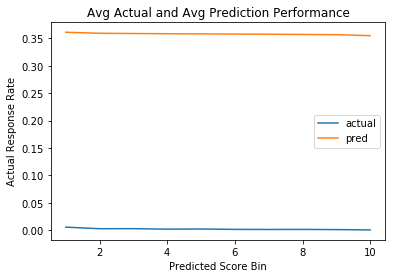

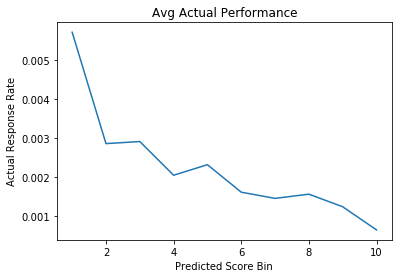

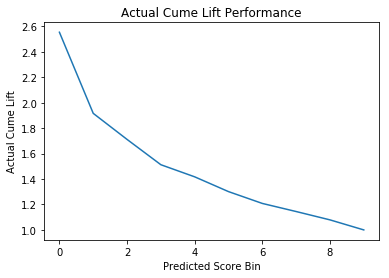

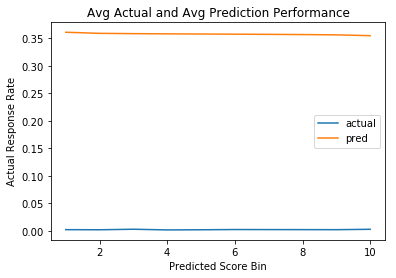

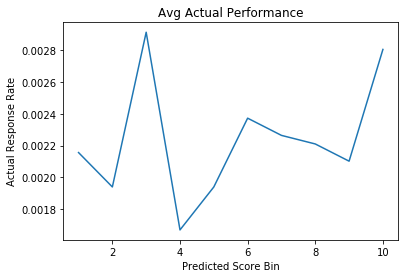

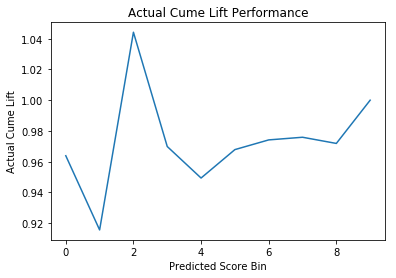

In [124]:
#just tuned catboost model

jan_18_topBal_x_A=jan_18_topBal_x.copy()
jan_18_topBal_y_A=jan_18_topBal_y.copy()


#jan_18_topBal_x_A,jan_18_topBal_y_A =oversample_2class(jan_18_topBal_x_A,pd.DataFrame(jan_18_topBal_y_A.values.reshape(jan_18_topBal_y_A.shape[0],1)),prop=0.01,seed=0,save_msk_path=None, shuffle=True)


hold_results=np.zeros((jan_18_topBal_x_A.shape[0],4))

kf = KFold(n_splits=20,random_state=4528996,shuffle=True)
counter =1

mod=CatBoostClassifier(iterations=10, depth=7, learning_rate=0.01, loss_function='Logloss', verbose=True,random_seed=4528,l2_leaf_reg=5)

jan_18_topBal_x_A=jan_18_topBal_x_A[keep_vars_linear]



for train_index, test_index in kf.split(jan_18_topBal_x_A.values):
    X_train, X_test = jan_18_topBal_x_A.iloc[train_index], jan_18_topBal_x_A.iloc[test_index]
    Y_train, Y_test = jan_18_topBal_y_A.values[train_index], jan_18_topBal_y_A.values[test_index]
    
    mod.fit(X_train.values, Y_train.ravel())
    pred_train=mod.predict_proba(X_train.values)[:,1]
    pred_test=mod.predict_proba(X_test.values)[:,1]
    
    
    
    hold_results[train_index,0]=Y_train.ravel()
    hold_results[train_index,1]=pred_train
    hold_results[test_index,2]=Y_test.ravel()
    hold_results[test_index,3]=pred_test
    
    print('fold '+ str(counter)+' completed.')
    
    counter= counter +1
    
    
d=np.column_stack([hold_results[:,0],hold_results[:,1]])
eval_model_results_binary(d,10)
    
d=np.column_stack([hold_results[:,2],hold_results[:,3]])
eval_model_results_binary(d,10)


#mod.fit(jan_18_topBal_x_A.values,jan_18_topBal_y_A.values.ravel())

#pd.DataFrame(zip(mod.feature_importances_, jan_18_topBal_x_A.columns),columns=['rank','var']).sort_values('rank', ascending=False)


In [122]:
mod.save_model('/user-home/1014/checking_models/response_rebuild/Final_highbal_resp.catboost')

,rank,var
178,33.484215,meanC_CHECKING_BAL_AMT_BG
176,8.205961,new_hhs_12_with_checking
6,4.413495,NUM_DEPOSITS_QTY_BG
181,3.860816,new_hhs_24
35,3.234773,PEN_CHECK
197,3.026858,BG_prop_all_check_24mon
55,2.619170,MT_Credit_Card_Revolvers_1256
71,2.574658,MDM_CKhousehold_ShareUB_BG
61,2.515219,Merit_Score_1881
159,2.495902,new_hhs_24_with_checking_BG


In [ ]:
#Linear model and then residuals with trees

jan_18_topBal_x_A=jan_18_topBal_x.copy()
jan_18_topBal_y_A=jan_18_topBal_y.copy()


hold_results=np.zeros((jan_18_topBal_x_A.shape[0],4))

kf = KFold(n_splits=20,random_state=4528996,shuffle=True)
counter =1


lr=Logist
mod=CatBoostClassifier(iterations=20, depth=7, learning_rate=0.01, loss_function='Logloss', verbose=True,random_seed=4528,l2_leaf_reg=0.05)

jan_18_topBal_x_A=jan_18_topBal_x_A[keep_vars_linear]



for train_index, test_index in kf.split(jan_18_topBal_x_A.values):
    X_train, X_test = jan_18_topBal_x_A.iloc[train_index], jan_18_topBal_x_A.iloc[test_index]
    Y_train, Y_test = jan_18_topBal_y_A.values[train_index], jan_18_topBal_y_A.values[test_index]
    
    
    #grid search
    mod.fit(X_train.values, Y_train.ravel())
  
    #use best model to predict test
    pred_test=mod.predict_proba(X_test.values)[:,1]
    
    
    #hold_results[train_index,0]=Y_train.ravel()
    #hold_results[train_index,1]=pred_train
    hold_results[test_index,2]=Y_test.ravel()
    hold_results[test_index,3]=pred_test
    
    print('fold '+ str(counter)+' completed.')
    
    counter= counter +1
    

    
d=np.column_stack([hold_results[:,2],hold_results[:,3]])
eval_model_results_binary(d,10)


#mod.fit(jan_18_topBal_x_A.values,jan_18_topBal_y_A.values.ravel())

pd.DataFrame(zip(mod.feature_importances_, jan_18_topBal_x_A.columns),columns=['rank','var']).sort_values('rank', ascending=False)

In [ ]:
    #linear model with a couple variables we understood from before are linearly related to the target
    X_train_l=X_train[keep_vars_linear].fillna(X_train[keep_vars_linear].mean())
    lr.fit(X_train_l.values,Y_train.ravel())
    pred_lr=lr.predict_proba(X_train_l.values)[:,1]
    
    print("lr")
    #calculate residual and make this the target for trees
    resid=Y_train.ravel()#-pred_lr
    
    ###################################
    #fit model to residuals############
    ###################################
    
    #first sample out dev for early stopping
    X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train, resid, test_size=0.20, random_state=42)
    
    #early stopping
    boostreg=CatBoostRegressor(iterations=1500, depth=5, learning_rate=0.1, loss_function='RMSE',nan_mode='Min',random_seed=42,od_type = "Iter",  od_wait = 20)
    boostreg.fit(X=X_train2, y=y_train2, eval_set =(X_test2, y_test2),use_best_model=True,cat_features=[0,29,813])
    
    #refit
    boostreg=CatBoostRegressor(iterations=boostreg.tree_count_, depth=5, learning_rate=0.1, loss_function='RMSE',nan_mode='Min',random_seed=42)
    boostreg.fit(X_train.values,resid,cat_features=[0,29,813])
    
    pred_boost=boostreg.predict(X_train.values)
    pred_train=pred_lr+pred_boost
    print("boost")
    
    
    
    
    
    
    
    #predicted both models on oof
    X_test_l=X_test[keep_vars_linear].fillna(X_test[keep_vars_linear].mean())
    pred_lr_oof=lr.predict_proba(X_test_l.values)[:,1]
    pred_boost_oof=boostreg.predict(X_test.values)
    pred_test = pred_lr_oof+pred_boost_oof
    print("preds")
 

fold 1 completed.
fold 2 completed.
fold 3 completed.
fold 4 completed.
fold 5 completed.
fold 6 completed.
fold 7 completed.
fold 8 completed.
fold 9 completed.
fold 10 completed.
fold 11 completed.
fold 12 completed.
fold 13 completed.
fold 14 completed.
fold 15 completed.
fold 16 completed.
fold 17 completed.
fold 18 completed.
fold 19 completed.
fold 20 completed.
AUC is: 0.61998255277
KS: 0.214037346254
Total Responders: 508.0
Lift Bin 1 (Vs Mean): 2.87401574803
Lift Bin 1 (Vs Last Bin): 3.94594594595


,Decile,Count,Responders,Actual Response Rate,Predicted Response Rate,Lift,Cume Count,Cume Responders,Cume Response Rate,Cume Lift,Min Predicted,Max Predicted
0,1,4150,146,0.035181,0.000001,2.874016,4150,146,0.035181,2.874016,0.000001,0.000028
1,2,4150,63,0.015181,0.000001,1.240157,8300,209,0.025181,2.057087,0.000001,0.000001
2,3,4150,36,0.008675,0.000001,0.708661,12450,245,0.019679,1.607612,0.000001,0.000001
3,4,4150,33,0.007952,0.000001,0.649606,16600,278,0.016747,1.368110,0.000001,0.000001
4,5,4150,44,0.010602,0.000001,0.866142,20750,322,0.015518,1.267717,0.000001,0.000001
5,6,4150,35,0.008434,0.000001,0.688976,24900,357,0.014337,1.171260,0.000001,0.000001
6,7,4150,43,0.010361,0.000001,0.846457,29050,400,0.013769,1.124859,0.000001,0.000001
7,8,4150,42,0.010120,0.000001,0.826772,33200,442,0.013313,1.087598,0.000001,0.000001
8,9,4150,29,0.006988,0.000001,0.570866,37350,471,0.012610,1.030184,0.000001,0.000001
9,10,4150,37,0.008916,0.000001,0.728346,41500,508,0.012241,1.000000,0.000001,0.000001


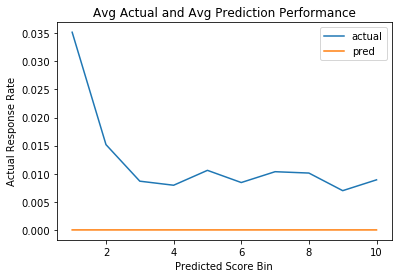

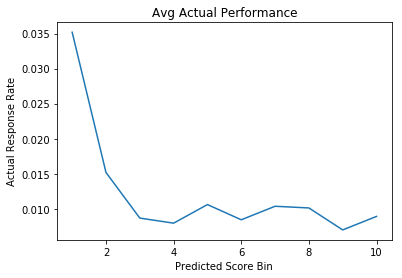

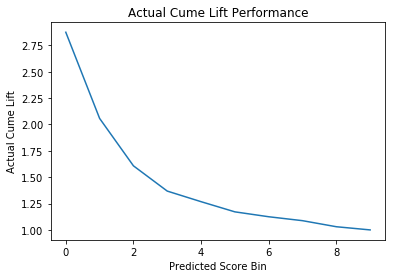

In [5]:
#original

jan_18_topBal_x_A=jan_18_topBal_x.copy()
jan_18_topBal_y_A=jan_18_topBal_y.copy()


jan_18_topBal_x_A,jan_18_topBal_y_A =oversample_2class(jan_18_topBal_x_A,pd.DataFrame(jan_18_topBal_y_A.values.reshape(jan_18_topBal_y_A.shape[0],1)),prop=0.01,seed=0,save_msk_path=None, shuffle=True)


hold_results=np.zeros((jan_18_topBal_x_A.shape[0],4))

kf = KFold(n_splits=20,random_state=4528996,shuffle=True)
counter =1

mod_2=lgb.LGBMClassifier(boosting_type='gbdt', 
              num_leaves=31, 
              max_depth=-1, 
              learning_rate=0.01, 
              n_estimators=30, 
              subsample_for_bin=200000, 
              objective='binary', 
              min_split_gain=0.0, 
              min_child_weight=0.001, 
              min_child_samples=50, 
              subsample=0.7, 
              subsample_freq=1, 
              colsample_bytree=0.7, 
              reg_alpha=0.0, 
              reg_lambda=0.001, 
              random_state=4528, 
              n_jobs=-1, 
              silent=True)
  
params_xg = {'booster': 'gbtree','max_depth':5, 'eta':0.05, 'silent':0, 'objective':'binary:logistic','nthread':8}



mod=CatBoostClassifier(iterations=40, depth=7, learning_rate=0.01, loss_function='Logloss', verbose=False, eval_metric="AUC",random_seed=4528)


jan_18_topBal_x_A=jan_18_topBal_x_A[keep_vars_linear]

for train_index, test_index in kf.split(jan_18_topBal_x_A.values):
    X_train, X_test = jan_18_topBal_x_A.iloc[train_index], jan_18_topBal_x_A.iloc[test_index]
    Y_train, Y_test = jan_18_topBal_y_A.values[train_index], jan_18_topBal_y_A.values[test_index]
    
    dtrain_xg=xgb.DMatrix(X_train.values, label=Y_train.ravel())
    dtest_xg=xgb.DMatrix(X_test.values, label=Y_test.ravel())

    
    
    mod.fit(X_train.values,Y_train.ravel())
    mod_2.fit(X_train.values,Y_train.ravel())
    
    mod_3=xgb.train(params=params_xg,dtrain=dtrain_xg,num_boost_round=25)
    
    
    pred_train=mod.predict_proba(X_train.values)[:,1]
    pred_test=mod.predict_proba(X_test.values)[:,1]
    pred_test2=mod_2.predict_proba(X_test.values)[:,1]
    pred_test3=mod_3.predict(dtest_xg)

    pred_test=(pred_test*pred_test2*pred_test3)**3
    
    hold_results[train_index,0]=Y_train.ravel()
    hold_results[train_index,1]=pred_train
    hold_results[test_index,2]=Y_test.ravel()
    hold_results[test_index,3]=pred_test
    
    print('fold '+ str(counter)+' completed.')
    
    counter= counter +1
    


mod.fit(jan_18_topBal_x_A.values,jan_18_topBal_y_A.values.ravel())
mod_2.fit(jan_18_topBal_x_A.values,jan_18_topBal_y_A.values.ravel())

dtrain_xg=xgb.DMatrix(jan_18_topBal_x_A.values, label=jan_18_topBal_y_A.values.ravel())
mod_3=xgb.train(params=params_xg,dtrain=dtrain_xg,num_boost_round=25)

pd.DataFrame(zip(mod.feature_importances_, jan_18_topBal_x_A.columns),columns=['rank','var']).sort_values('rank', ascending=False)

d=np.column_stack([hold_results[:,2],hold_results[:,3]])
eval_model_results_binary(d,10)

#d=np.column_stack([hold_results[:,0],hold_results[:,1]])
#eval_model_results_binary(d,10)

In [62]:
mod.save_model('/user-home/1014/checking_models/response_rebuild/mod_1_highbal_resp.catboost')
mod_2.booster_.save_model('/user-home/1014/checking_models/response_rebuild/mod_1_highbal_resp.lgbm')
mod_3.save_model('/user-home/1014/checking_models/response_rebuild/mod_1_highbal_resp.xgb')

In [100]:
test=pd.read_csv('/user-home/1014/checking_models/response_rebuild/MAR_18_checking_model_data.txt')

test['DMA_602']=np.where(test.DMA_176.values ==602,1,0)
test['DMA_539']=np.where(test.DMA_176.values ==539,1,0)
test['DMA_505']=np.where(test.DMA_176.values ==505,1,0)
test['DMA_510']=np.where(test.DMA_176.values ==510,1,0)
test['DMA_524']=np.where(test.DMA_176.values ==524,1,0)
test['DMA_534']=np.where(test.DMA_176.values ==534,1,0)
test['DMA_517']=np.where(test.DMA_176.values ==517,1,0)
test['DMA_535']=np.where(test.DMA_176.values ==535,1,0)
test['DMA_528']=np.where(test.DMA_176.values ==528,1,0)
test['DMA_515']=np.where(test.DMA_176.values ==515,1,0)
test['DMA_527']=np.where(test.DMA_176.values ==527,1,0)
test['DMA_563']=np.where(test.DMA_176.values ==563,1,0)
test['DMA_659']=np.where(test.DMA_176.values ==659,1,0)
test['DMA_571']=np.where(test.DMA_176.values ==571,1,0)
test['DMA_529']=np.where(test.DMA_176.values ==529,1,0)
test['DMA_542']=np.where(test.DMA_176.values ==542,1,0)
test['DMA_561']=np.where(test.DMA_176.values ==561,1,0)
test['DMA_548']=np.where(test.DMA_176.values ==548,1,0)
test['DMA_513']=np.where(test.DMA_176.values ==513,1,0)
test['DMA_547']=np.where(test.DMA_176.values ==547,1,0)
test['DMA_560']=np.where(test.DMA_176.values ==560,1,0)


# Advantage_Target_Income_20_876   
d1={1:1,
2:2,
3:3,
4:4,
5:5,
6:6,
7:7,
8:8,
9:9,
'A':10,
'B':11,
'C':12,
'D':13
}


d2={'Y':1, 'N':0}

#target value score
d3={'A1':1.0,
'A2':2.0,
'B1':3.0,
'B2':4.0,
'C1':5.0,
'C2':6.0,
'D1':7.0,
'D2':8.0,
'D3':9.0
}

#merit score,TriggerVal_ValueScore_1060
d4={'A1':1.0,
'A2':2.0,
'B1':3.0,
'B2':4.0,
'C1':5.0,
'C2':6.0,
'D1':7.0,
'D2':8.0,
'D3':9.0,
'E1':10.0,
'E2':11.0,
'E3':12.0
}


d5={
'A':'10',
'B':'11',
'C':'12',
'D':'13'
}

d6={
'N':'0',
'D':'1',
'I':'-1',
}

d7={
'A':1.0,
    'B':2.0,
    'C':3.0,
    'D':4.0,
    'E':5.0,
    'F':6.0,
    'G':7.0,
    'H':8.0,
    'I':9.0,
    'J':10.0,
    'K':11.0,
    'L':12.0,
    'M':13.0,
    'N':14.0,
    'O':15.0,
    'P':16.0,
    'Q':17.0,
    'Z':18.0
            
}

test['TriggerVal_Home_Market_Valu_1002']=test.TriggerVal_Home_Market_Valu_1002.map(d7)



test['Credit_Card_Trigger_978']=test.Credit_Card_Trigger_978.fillna('N').map(d6)
test['Home_Market_Value_Trigger_1001']=test.Home_Market_Value_Trigger_1001.fillna('N').map(d6)
test['Income_Trigger_1009']=test.Income_Trigger_1009.fillna('N').map(d6)
test['ValueScore_Trigger_1059']=test.ValueScore_Trigger_1059.fillna('N').map(d6)
test['Niche_Switch_Trigger_1068']=test.Niche_Switch_Trigger_1068.fillna('N').map(d6)


#update when dict is not exhuastive (and is inplace!)
test['TriggerVal_Income_1010'].update(test['TriggerVal_Income_1010'].map(d5))
test['TriggerVal_Income_1010']=test['TriggerVal_Income_1010'].fillna('0').astype(float)





test['TriggerVal_ValueScore_1060']=test['TriggerVal_ValueScore_1060'].map(d4)  


test['Merit_Score_1881']=test['Merit_Score_1881'].map(d4)  

test['Mobility_Score_1878']=test['Mobility_Score_1878'].map(d4) 

test['Target_ValueScore_20_All_614']=test['Target_ValueScore_20_All_614'].map(d3)  
test['Target_ValueScore_20_Aut_616']=test['Target_ValueScore_20_Aut_616'].map(d3) 
test['Target_ValueScore_20_Ban_618']=test['Target_ValueScore_20_Ban_618'].map(d3)  
test['Target_ValueScore_20_Ret_620']=test['Target_ValueScore_20_Ret_620'].map(d3)  

test['Investments_and_Insurance_739'].fillna('N',inplace=True)
test['Investments_and_Insurance_744'].fillna('N',inplace=True)
test['Investments_and_Insurance_739']= test['Investments_and_Insurance_739'].map(d2)   
test['Investments_and_Insurance_744']= test['Investments_and_Insurance_744'].map(d2)  

test['Target_Home_Market_Value_894_v']=test.Target_Home_Market_Value_894.str[0:4].fillna(0).astype(float)  
test['Advantage_Target_Income_20_876']=test['Advantage_Target_Income_20_876'].map(d1)  


test['Current_Loan_to_Value_890']=test['Current_Loan_to_Value_890'].fillna(0).astype(float) 
test['Available_home_equity_in_th_899']=test['Available_home_equity_in_th_899'].fillna(0).astype(float)  
test['Advantage_Length_of_Residen_823']=test['Advantage_Length_of_Residen_823'].fillna(0).astype(float)  
test['Target_PreMover_20_Model_879']=test['Target_PreMover_20_Model_879'].fillna(0).astype(float)  

test['Gold_Wallets_1100'].fillna('N',inplace=True)
test['Silver_Wallets_1102'].fillna('N',inplace=True)
test['Platinum_Wallets_1101'].fillna('N',inplace=True)

test['Gold_Wallets_1100']= test['Gold_Wallets_1100'].map(d2)
test['Silver_Wallets_1102']= test['Silver_Wallets_1102'].map(d2) 
test['Platinum_Wallets_1101']= test['Platinum_Wallets_1101'].map(d2)   

test['Liquid_Resources_1093']=test['Liquid_Resources_1093'].astype(float)  
test['Wealth_Resources_1089']=test['Wealth_Resources_1089'].astype(float)  
test['Investment_Resources_1091']=test['Investment_Resources_1091'].astype(float)  


test['income_diff']=test['Advantage_Target_Income_20_876']-test['TriggerVal_Income_1010']

test=test.drop(['Target_Home_Market_Value_894'],axis=1)


test['MDM_household_Share_BG_ixi']=test['MDM_household_Share_BG'] / test['total']
test['PEN_CHECK']=test['SUM_CHECKING_IND_BG'] / test['total_ixi_check_custs']
test['peraddress_53']=test['sum_fifth_third'] / test['addresses_CT']
test['peraddress_bc']=test['total_bankingcenters'] / test['addresses_CT']
test['checking_pen_53_MA_Custs']=test['checking_MA']/test['MA']
test['checking_pen_53_MA_Custs_BG']=test['checking_MA_BG']/test['MA_BG']


y_true=test.responder

/opt/conda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (5,38,39,48,49,50) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
#march18_score=pd.read_csv('/user-home/1014/checking_models/response_rebuild/MAR_18_preds.txt')
#test=pd.merge(test,march18_score,how='inner',left_on=['Person_Seq_No_1_183'], right_on=['Person_Seq_No_1_183'])

In [112]:
test_score=test[keep_vars_linear]
test_pred=mod.predict_proba(test_score.values)[:,1]

cuts=[0,
0.069409,
0.072772,
0.075045,
0.076778,
0.078275,
0.079673,
0.08097,
0.082384,
0.084293,
1
]

AUC is: 0.50884940629
KS: 0.0183723865522
Total Responders: 5510.0
Lift Bin 1 (Vs Mean): 1.08529765463
Lift Bin 1 (Vs Last Bin): 1.08727272727


,Decile,Count,Responders,Actual Response Rate,Predicted Response Rate,Lift,Cume Count,Cume Responders,Cume Response Rate,Cume Lift,Min Predicted,Max Predicted
0,1,241057,598,0.002481,0.087679,1.085298,241057,598,0.002481,1.085298,0.085468,0.118701
1,2,241056,605,0.002510,0.084438,1.098006,482113,1203,0.002495,1.091652,0.083553,0.085468
2,3,241057,542,0.002248,0.082824,0.983664,723170,1745,0.002413,1.055656,0.082126,0.083553
3,4,241056,516,0.002141,0.081463,0.936481,964226,2261,0.002345,1.025862,0.080812,0.082126
4,5,241057,540,0.002240,0.080129,0.980035,1205283,2801,0.002324,1.016697,0.079427,0.080812
5,6,241056,554,0.002298,0.078681,1.005447,1446339,3355,0.002320,1.014822,0.077908,0.079427
6,7,241057,571,0.002369,0.077057,1.036296,1687396,3926,0.002327,1.017890,0.076155,0.077908
7,8,241056,512,0.002124,0.075103,0.929222,1928452,4438,0.002301,1.006806,0.073949,0.076155
8,9,241057,522,0.002165,0.072363,0.947367,2169509,4960,0.002286,1.000202,0.070445,0.073949
9,10,241057,550,0.002282,0.065922,0.998183,2410566,5510,0.002286,1.000000,0.041512,0.070445


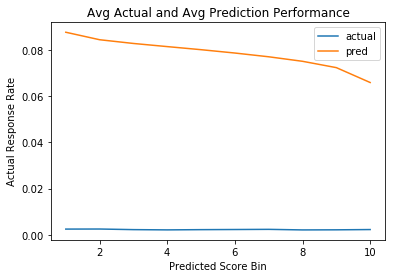

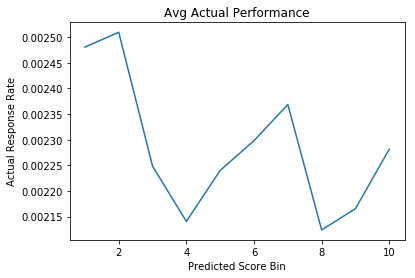

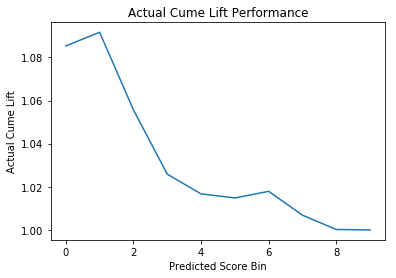

In [113]:
d=np.column_stack([y_true.values,test_pred])
eval_model_results_binary(d,10)

5510


,count,mean,sum
decile,,,
0,375764,0.002499,939
1,302014,0.002308,697
2,257483,0.002210,569
3,228649,0.002244,513
4,226372,0.002240,507
5,215953,0.002362,510
6,211011,0.002171,458
7,208063,0.002201,458
8,192413,0.002256,434


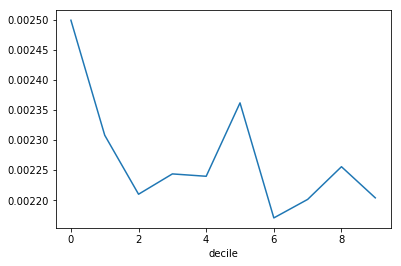

In [117]:
labels=[1,2,3,4,5,6,7,8,9,10]


df_test=pd.DataFrame(test_pred,columns=['pred'])
df_test['actual']=y_true
df_test['decile']=pd.cut(df_test.pred,bins=cuts,right=True,labels=labels)
df_test['decile']=10-df_test['decile']
df_test.groupby('decile')['actual'].mean().plot()
print(y_true.sum())
df_test.groupby('decile')['actual'].agg(['count','mean', 'sum'])

AUC is: 0.648364795205
KS: 0.231973436722
Total Responders: 508.0
Lift Bin 1 (Vs Mean): 3.0905511811
Lift Bin 1 (Vs Last Bin): 6.28


,Decile,Count,Responders,Actual Response Rate,Predicted Response Rate,Lift,Cume Count,Cume Responders,Cume Response Rate,Cume Lift,Min Predicted,Max Predicted
0,1,4150,157,0.037831,0.086490,3.090551,4150,157,0.037831,3.090551,0.084294,0.109796
1,2,4150,61,0.014699,0.083267,1.200787,8300,218,0.026265,2.145669,0.082384,0.084293
2,3,4150,46,0.011084,0.081667,0.905512,12450,264,0.021205,1.732283,0.080970,0.082384
3,4,4150,39,0.009398,0.080322,0.767717,16600,303,0.018253,1.491142,0.079673,0.080970
4,5,4150,34,0.008193,0.078968,0.669291,20750,337,0.016241,1.326772,0.078275,0.079673
5,6,4150,38,0.009157,0.077542,0.748031,24900,375,0.015060,1.230315,0.076778,0.078275
6,7,4150,36,0.008675,0.075937,0.708661,29050,411,0.014148,1.155793,0.075047,0.076778
7,8,4150,38,0.009157,0.073965,0.748031,33200,449,0.013524,1.104823,0.072773,0.075045
8,9,4150,34,0.008193,0.071269,0.669291,37350,483,0.012932,1.056430,0.069410,0.072772
9,10,4150,25,0.006024,0.065256,0.492126,41500,508,0.012241,1.000000,0.043023,0.069409


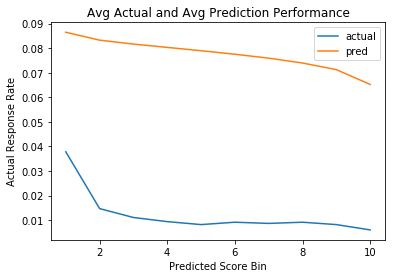

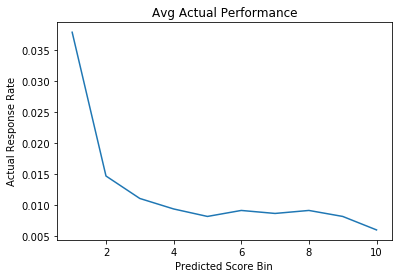

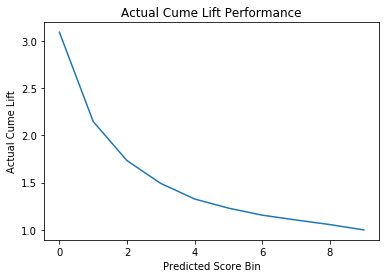

In [111]:
#final catboost OOF performance    
d=np.column_stack([hold_results[:,2],hold_results[:,3]])
eval_model_results_binary(d,10)

In [1]:
!free -m

             total       used       free     shared    buffers     cached
Mem:        251643     130030     121612         85          7      78283
-/+ buffers/cache:      51739     199903
Swap:         4095         70       4025


In [9]:
full=pd.read_csv('/user-home/1014/checking_models/response_rebuild/checking_model_data.txt', na_values=['.', 'null'], dtype={'block_group':np.object, 'census_tract': np.object})
print(full.CAMPAIGN.value_counts())
print(full.responder.value_counts())
full=full.loc[(full.CAMPAIGN.isin(['OCT17','SEP17','JUL17'])) &(full.responder==1 ) ][['Person_Seq_No_1_183','ACCT_KEY','hh_key','OPEN_DATE','date_key_link','CAMPAIGN']]

scores=pd.read_csv('/user-home/1014/checking_models/response_rebuild/scores.txt', na_values=['.', 'null'])
full=pd.merge(full,scores,how='left',left_on=['CAMPAIGN','Person_Seq_No_1_183'], right_on=['campaign','Person_Seq_No_1_183'])



MAR17    1155090
JAN18     555001
OCT17     277501
SEP17     111001
JUL17     111000
Name: CAMPAIGN, dtype: int64
0    2205515
1       4078
Name: responder, dtype: int64


In [10]:

def resp_decile_classify(x): 
    if x >= 0.02016828: 
        resp_decile_range=1 
    elif x >=0.0183238479987624 and x < 0.02016828:
        resp_decile_range=2
    elif x >=0.0171368020008659 and x < 0.0183238479987624:
        resp_decile_range=3
    elif x >=0.0162066398244529 and x < 0.0171368020008659 :
        resp_decile_range=4
    elif x >=0.0153569084145478 and x < 0.0162066398244529:
        resp_decile_range=5    
    elif x >=0.0145335720355378 and x < 0.0153569084145478:
        resp_decile_range=6
    elif x >=0.0136686706768234 and x < 0.0145335720355378:
        resp_decile_range=7
    elif x >=0.0126610871036991 and x < 0.0136686706768234:
        resp_decile_range=8
    elif x >=0.0111844466793064 and x < 0.0126610871036991:
        resp_decile_range=9
    elif x < 0.0111844466793064:
        resp_decile_range=10
    
    return(resp_decile_range)

full['decile_range']=full.pred.apply(resp_decile_classify) 

In [11]:
full.head()

,Person_Seq_No_1_183,ACCT_KEY,hh_key,OPEN_DATE,date_key_link,CAMPAIGN,campaign,pred,decile_range
0,0C0080FA030F360004BAAD,72435741.0,76234418.0,19JUL2017,20970,JUL17,JUL17,0.011391,9
1,0C00821C030F9900032DE3,72435174.0,76102159.0,19JUL2017,20970,JUL17,JUL17,0.013675,7
2,0C00822C031063000B98A8,72787528.0,74845909.0,24AUG2017,20970,JUL17,JUL17,0.012621,9
3,0C0080EC031320001C4276,72865828.0,NaN,30AUG2017,20970,JUL17,JUL17,0.012451,9
4,0C0080FC03119000397E4C,72845489.0,NaN,28AUG2017,20970,JUL17,JUL17,0.012005,9


In [14]:
#read in Jan 2018 scored (balance model)
jan_bal_model=pd.read_csv('/user-home/1014/checking_models/score/scored.csv')

full=full.drop('pred',axis=1)


final=pd.merge(full,jan_bal_model,how='inner',left_on=['Person_Seq_No_1_183'], right_on=['Person_Seq_No_1_183'])

In [18]:
def decile_classify(x):
    if x >= 6.101732:
        decile_range='High_High'
    elif x < 6.101732 and x >= 5.622079 :
        decile_range="High"
    elif x < 5.622079 and x >= 4.215497:
        decile_range="Medium"
    elif x < 4.215497:
        decile_range ="Low"
    return(decile_range)


final['bal_range']=final.pred.apply(decile_classify)

In [20]:
final.groupby(['bal_range']).size()

bal_range
High         250
High_High    126
Low          260
Medium       745
dtype: int64

In [21]:
final.to_csv('/user-home/1014/checking_models/score/responder_analysis.csv',index=False)